## Import libraries

In [1]:
# Jupyter notebook magic command for inline plotting
%matplotlib inline

# Import libraries
import numpy as np
import sys
import xarray as xr
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import pearsonr
import glob
import warnings
import os
import pandas as pd
from cartopy import config
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# ECCOv4-py library for ocean state estimates
from os.path import join, expanduser

# Add ECCOv4-py to the system path
user_home_dir = expanduser('~')
sys.path.append(join(user_home_dir, 'ECCOv4-py'))
import ecco_v4_py as ecco

# Set up Jupyter notebook display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Display the library versions
print("Library versions:")
print(f"NumPy version: {np.__version__}")
print(f"Xarray version: {xr.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Scipy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

Library versions:
NumPy version: 1.26.0
Xarray version: 2023.9.0
Matplotlib version: 3.7.2
Scipy version: 1.26.0
Pandas version: 2.0.3


## Load ECCO Data for Analysis

In [2]:
# Set the top-level directory
usb_drive_path = "/Volumes/Liliana"

# Define the ECCO directory
ECCO_dir = os.path.join(usb_drive_path, 'ECCO_V4r4_PODAAC')

# Load ECCO Data - Timeframe = '2010-2016' -> Data chosen to be analyzed
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir, '*GEOMETRY*', '*.nc'))[0])

# Load data - Timeframe = '2010-2016' - Data chosen to be analyzed
OBP_monthly_files = glob.glob(join(ECCO_dir, '*OBP*05*MONTHLY*', '*_201[0-6]-??_*.nc'))

# Load each file into memory 
def ds_load_concat(file_list, dim_concat, vars_to_drop):
    for count, file in enumerate(file_list):
        if count == 0:
            ds_out = xr.open_dataset(file).drop_vars(vars_to_drop)
        else:
            ds_curr = xr.open_dataset(file).drop_vars(vars_to_drop)
            ds_out = xr.concat((ds_out, ds_curr), dim=dim_concat)
    return ds_out

# Create a new dataset by loading, concatenating, and cleaning the OBP_monthly_files.
ds_OBP_monthly = ds_load_concat(OBP_monthly_files, dim_concat='time', vars_to_drop=['OBPGMAP'])

# Sort dataset by resampled time dimension
ds_OBP_monthly = ds_OBP_monthly.sortby('time')

# Merge two datasets 'ecco_grid' and 'ds_OBP_monthly'
# ecco_monthly_ds_OBP = xr.merge((ecco_grid, ds_OBP_monthly))

# Load ECCO Data - Timeframe = '2002-2016' -> Data chosen to be analyzed
SSH_monthly_files = glob.glob(join(ECCO_dir, '*SSH*05*MONTHLY*', '*_201[0-6]-??_*.nc'))

# Create a new dataset by loading, concatenating, and cleaning the OBP_monthly_files_2.
ds_SSH_monthly = ds_load_concat(SSH_monthly_files, dim_concat='time', vars_to_drop=['SSHNOIBC', 'SSHIBC'])

# Sort dataset by resampled time dimension
ds_SSH_monthly = ds_SSH_monthly.sortby('time')

# Merge two datasets 'ecco_grid' and 'ds_OBP_monthly' | 'ecco_monthly_ds_2' and 'ecco_monthly_ds' 
# ecco_monthly_ds_SSH = xr.merge((ecco_grid, ds_SSH_monthly))

## Pearson correlation coefficient

In [3]:
# Extract SSH and OBP variables
ssh = ds_SSH_monthly['SSH']
obp = ds_OBP_monthly['OBP']

# Replace NaN and Inf values with a fill value (e.g., 0)
ssh = ssh.fillna(0)
obp = obp.fillna(0)

# Calculate the Pearson correlation coefficient along the time dimension
correlation_coefficient = xr.corr(ssh, obp, dim='time')

# Create a new xarray dataset with the correlation coefficient values
ds_correlation = correlation_coefficient.rename('pearson_correlation_coefficient')
ds_correlation.coords['latitude'] = ssh.latitude
ds_correlation.coords['longitude'] = ssh.longitude


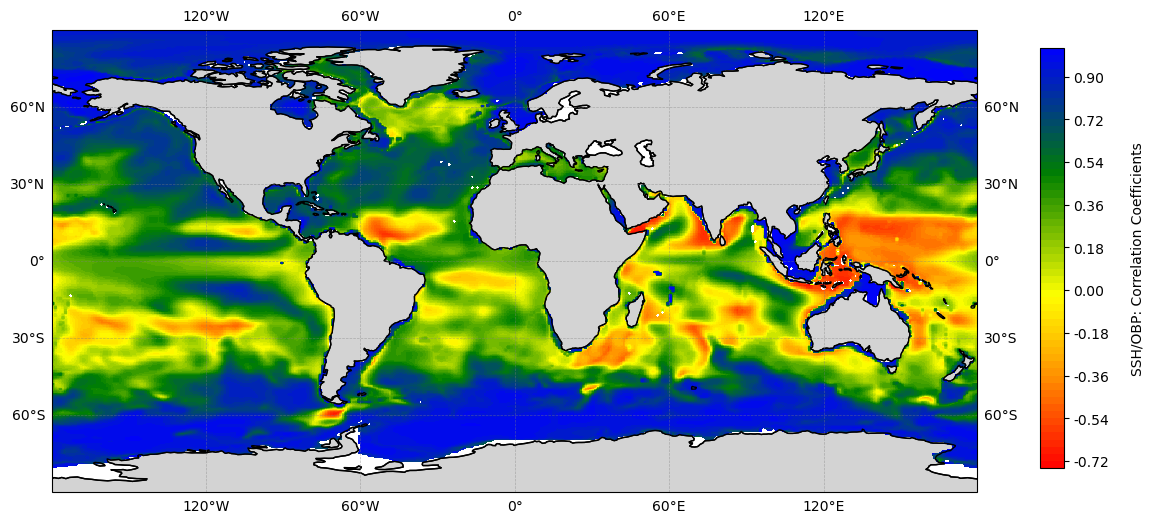

In [5]:
# Create a figure with specified size and dpi
fig = plt.figure(figsize=(12, 6), dpi=100)

# Set the projection for the plot as Plate Carrée
ax = plt.axes(projection=ccrs.PlateCarree())

# Specify data for plotting
x = ds_correlation.longitude
y = ds_correlation.latitude
tile_to_plot = ds_correlation 

# Define a diverging colormap with additional colors
cmap = LinearSegmentedColormap.from_list(
    'custom_cmap', [(0, 'red'), (0.25, 'orange'), (0.41, 'yellow'), (0.7, 'green'), (1, 'blue')]
)

# Plot filled contours with the custom colormap
cf = plt.contourf(x, y, tile_to_plot, 60, transform=ccrs.PlateCarree(), cmap=cmap)

# Add gridlines on the plot with specified properties
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Add coastlines to the plot
ax.coastlines()

# Add land feature to the plot
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')

# Add title and labels with increased spacing
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Add a colorbar to the plot without overlapping the main plot
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.7])  # Adjusted position
cbar = plt.colorbar(cf, ax=ax, cax=cbar_ax, format='%.2f')  # Format colorbar tick labels to two decimal places
cbar.set_label('SSH/OBP: Correlation Coefficients', labelpad=15)  # Increased spacing for colorbar title

# Save the plot
plt.savefig('SSH_OBP_correlation_coefficients_plot.png', bbox_inches='tight')

# Display the plot
plt.show()